<a href="https://www.kaggle.com/code/moazeldsokyx/plant-leaf-diseases-classification-using-cnn?scriptVersionId=153089417" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os

dataset_path = r"/kaggle/input/plantvillage/dataset"

os.listdir(dataset_path)

['validation', 'test', 'train']

In [7]:
train_path = os.path.join(dataset_path, 'train')
validation_path = os.path.join(dataset_path, 'validation')
test_path = os.path.join(dataset_path, 'test')

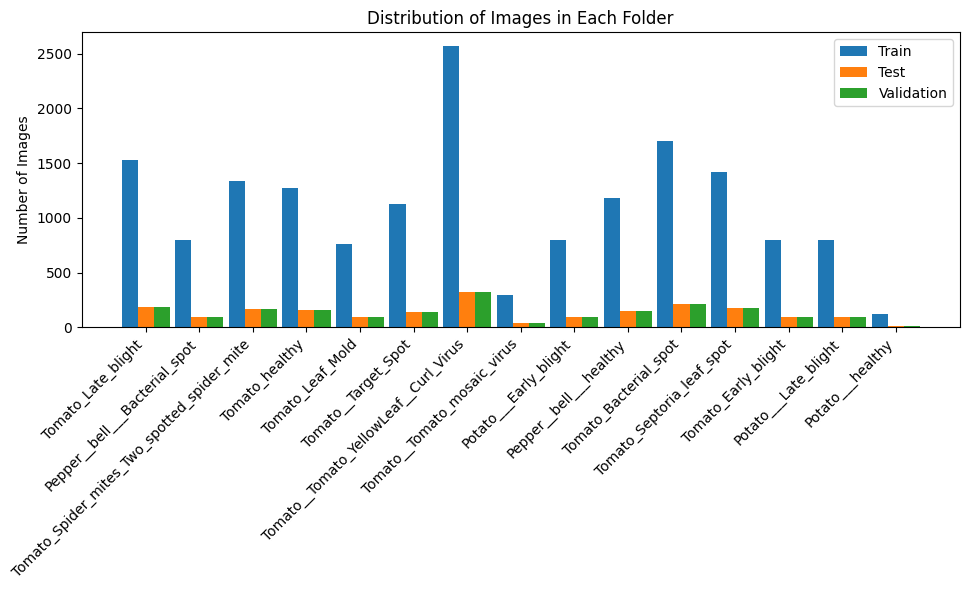

In [8]:
import os
import matplotlib.pyplot as plt
import numpy as np

folders = ['train', 'test', 'validation']

subfolder_lengths = {folder: {} for folder in folders}

for folder in folders:
    subfolders = os.listdir(os.path.join(dataset_path, folder))
    for subfolder in subfolders:
        subfolder_length = len(os.listdir(os.path.join(dataset_path, folder, subfolder)))
        subfolder_lengths[folder][subfolder] = subfolder_length

subfolder_names = list(subfolder_lengths['train'].keys())
train_lengths = list(subfolder_lengths['train'].values())
test_lengths = list(subfolder_lengths['test'].values())
val_lengths = list(subfolder_lengths['validation'].values())

x = np.arange(len(subfolder_names))
width = 0.3

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width, train_lengths, width, label='Train')
rects2 = ax.bar(x, test_lengths, width, label='Test')
rects3 = ax.bar(x + width, val_lengths, width, label='Validation')


ax.set_ylabel('Number of Images')
ax.set_title('Distribution of Images in Each Folder')
ax.set_xticks(x)
ax.set_xticklabels(subfolder_names, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()


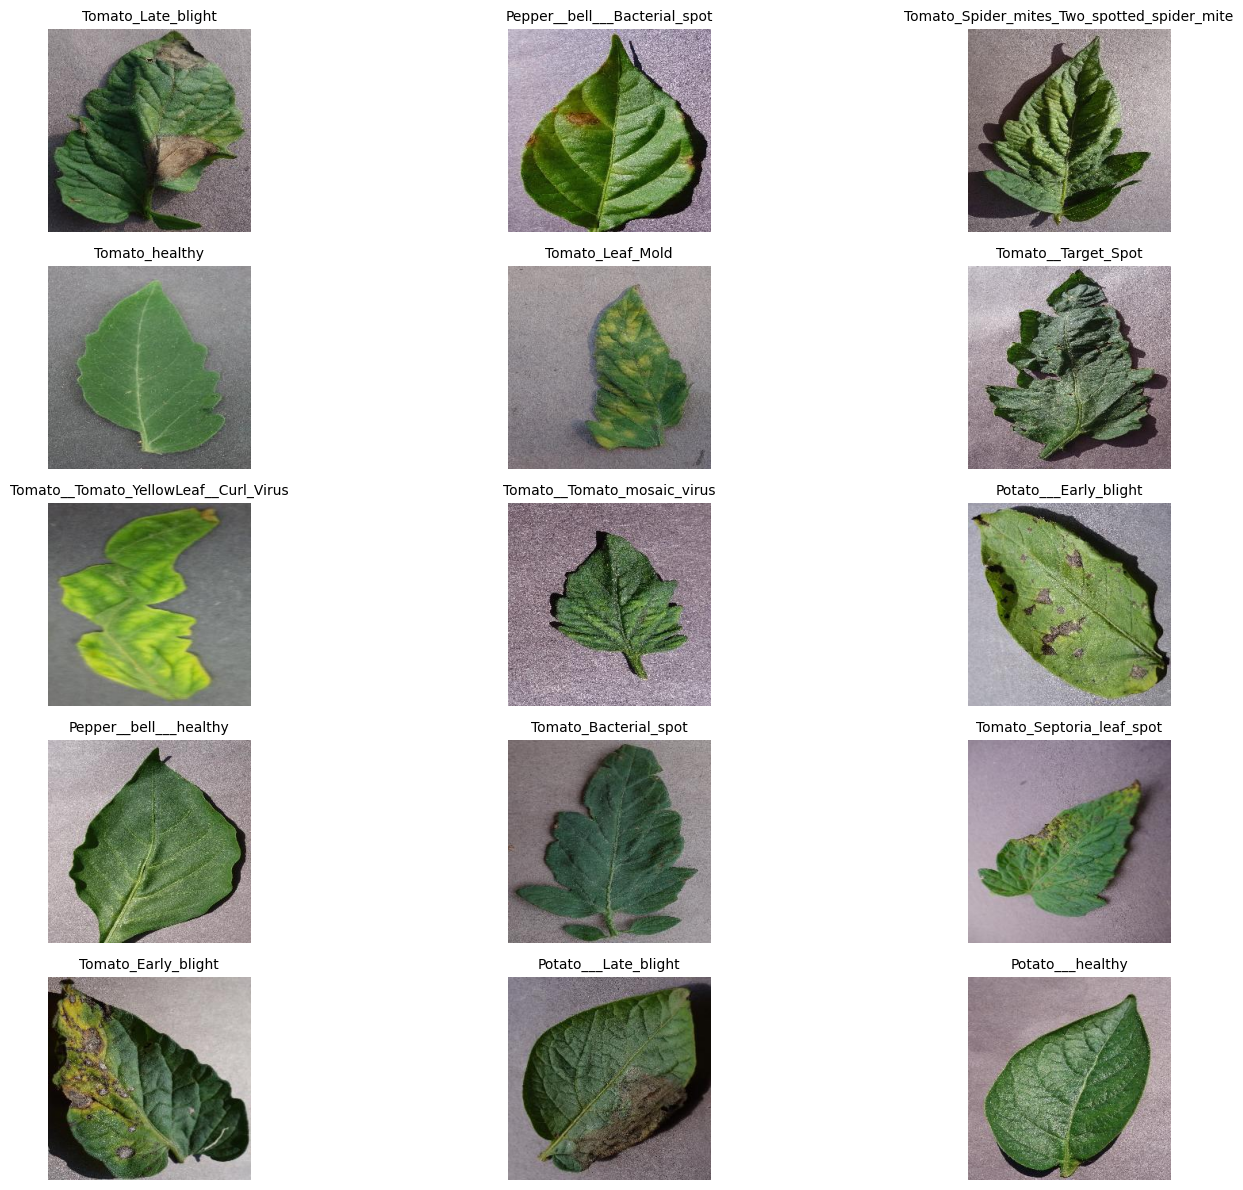

In [9]:
import matplotlib.image as mpimg

# Create a grid to display the images
num_cols = 3  # Number of columns in the grid
num_rows = 5  # Calculate number of rows

# Create a matplotlib figure and axis
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 12))
axes = axes.ravel()  # Flatten the axes array for easier indexing

# Loop through subfolders and display an image from each
for i, subfolder in enumerate(subfolders):
    img = [image for image in os.listdir(os.path.join(train_path,subfolder))][0]

    img_path = os.path.join(train_path, subfolder, img)  # Get the first image in the subfolder
    img = mpimg.imread(img_path)  # Load the image
    axes[i].imshow(img)
    axes[i].axis('off')  # Turn off axis labels
    axes[i].set_title(subfolder, color='black', fontsize=10)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
batch_size = 32
image_shape = (256,256)

train_datagen = ImageDataGenerator(

    rescale=1/255,
    shear_range=0.2,
    horizontal_flip = True,
    vertical_flip = True,
    brightness_range=[0.5, 1.5],  # Adjust brightness between 50% and 150%
    rotation_range=40,  # Rotate images by up to 40 degrees
    zoom_range = 0.2

)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = image_shape,
    batch_size = batch_size,
    class_mode = "categorical"

)

Found 16504 images belonging to 15 classes.


In [12]:
validation_datagen = ImageDataGenerator(
    rescale=1/255,
)

validation_generator = validation_datagen.flow_from_directory(
    validation_path,
    target_size = image_shape,
    batch_size = batch_size,
    class_mode = "categorical"

)

Found 2070 images belonging to 15 classes.


In [13]:
test_datagen = ImageDataGenerator(
    rescale=1/255,
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size = image_shape,
    batch_size = batch_size,
    class_mode = "categorical",
    shuffle = False

)

Found 2064 images belonging to 15 classes.


In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

tf.random.set_seed(42)

# Build your CNN model

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))

model.add(Dense(15, activation='softmax'))

# Compile the model

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy', metrics=['accuracy'])


# Define a ModelCheckpoint callback to save the best weights during training
checkpoint_callback = ModelCheckpoint("best_epoch_weights.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

model.summary()

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 254, 254, 32)      896       

                                                                 

 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         

 )                                                               

                                                                 

 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     

                                                                 

 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         

 2D)                                                             

                                                                 

 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     

                                                                 

 max_pooling2d_2 (MaxPooling  (None, 30,

In [18]:
# Train the model
tf.random.set_seed(42)

steps_per_epoch = train_generator.n // batch_size     # 32
validation_steps = validation_generator.n // batch_size
epochs = 20

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint_callback]
)

# Find the epoch with the best accuracy on the validation (test) set
best_epoch = np.argmax(history.history['val_accuracy']) + 1

print(f"Best epoch is ==> epoch {best_epoch}")

Epoch 1/20

515/515 [==============================] - ETA: 0s - loss: 1.5833 - accuracy: 0.4794

Epoch 1: val_accuracy improved from -inf to 0.57178, saving model to best_epoch_weights.h5

515/515 [==============================] - 314s 584ms/step - loss: 1.5833 - accuracy: 0.4794 - val_loss: 1.5165 - val_accuracy: 0.5718

Epoch 2/20

515/515 [==============================] - ETA: 0s - loss: 0.8553 - accuracy: 0.7099

Epoch 2: val_accuracy improved from 0.57178 to 0.73193, saving model to best_epoch_weights.h5

515/515 [==============================] - 293s 570ms/step - loss: 0.8553 - accuracy: 0.7099 - val_loss: 0.8454 - val_accuracy: 0.7319

Epoch 3/20

515/515 [==============================] - ETA: 0s - loss: 0.6641 - accuracy: 0.7751

Epoch 3: val_accuracy improved from 0.73193 to 0.78271, saving model to best_epoch_weights.h5

515/515 [==============================] - 289s 562ms/step - loss: 0.6641 - accuracy: 0.7751 - val_loss: 0.6680 - val_accuracy: 0.7827

Epoch 4/20

515/

In [22]:
# Load the weights of the best model
best_model = model

# Compile the best_model
best_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

best_model.load_weights(r'/content/best_epoch_weights.h5')

best_model.save("plant_leaf_diseases_model.h5")
# Now you can use the 'best_model' for predictions or further evaluation
print("Training done and best model saved")

Training done and best model saved


In [24]:
evaluation = best_model.evaluate(test_generator,verbose=0)
print(f"Test Accuracy = {round(evaluation[1],2)}")
print(f"Test Loss = {round(evaluation[0],3)}")

Test Accuracy = 0.96

Test Loss = 0.12


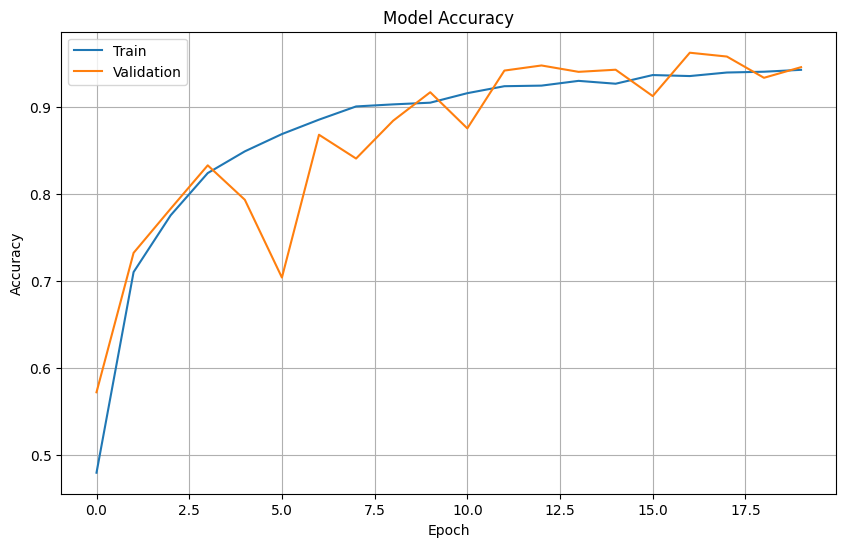

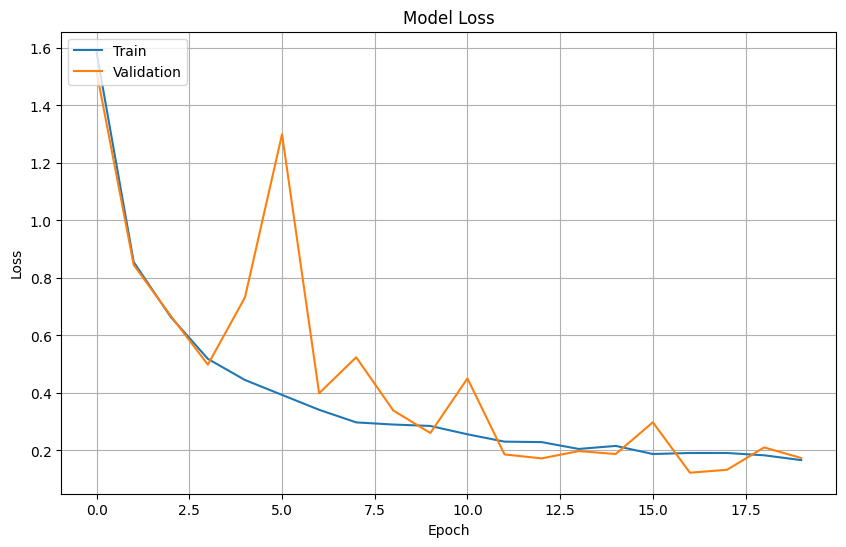

In [25]:
import matplotlib.pyplot as plt

# Assuming 'history' is the history object returned from model.fit()

# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()
